In [49]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, RepeatedKFold
import numpy as np
from itertools import combinations
import statsmodels.api as sm
import statsmodels.tools as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import time
import matplotlib.pyplot as plt
import pprint
import statistics
import time
%matplotlib inline

In [64]:
# response = 'rheomix final deg time min'
response = 'rheomix stability time min'

redo = 5
rorder = 1

In [65]:
if response == 'rheomix final deg time min':
    K_set = 'k20'
    K_num = 20
elif response == 'rheomix stability time min':
    K_set = 'LOO'
    K_num = 46

In [66]:
file1 = 'Total_model_subset_{}_Kfold_{}.csv'.format(response, K_set)
df_kfold = pd.read_csv(file1)

In [67]:
file1 = 'Total_model_subset_{}_AIC_BIC_AICc.csv'.format(response)
df_template = pd.read_csv(file1)

In [68]:
model_kfold = df_kfold['Model'][df_kfold[K_set].argmax()]
model_AICc = df_template['Model'][df_template.AICc.argmin()]
model_BIC = df_template['Model'][df_template.BIC.argmin()]
model_AIC = df_template['Model'][df_template.AIC.argmin()]
model_list1 = [model_AICc, model_BIC, model_AIC]


k_kfold = 1+df_kfold[df_kfold['Model'] == model_kfold][K_set].item()

In [69]:
def import_data(experimental_file, response_file, response):
    'imports data'
    'experimental_file = experimental design csv filename i.e experimental.csv'
    'response_file = results csv filename i.e Response.csv'
    'response = reponse name: i.e rheomix final deg time min or rheomix stability time min'
    
    experimental_df = pd.read_csv(experimental_file)
    response_df = pd.read_csv(response_file)
    
    X = experimental_df[experimental_df.columns.values.tolist()[1:]].values
    y = response_df[response].values
    max1 = max(y)
    min1 = min(y)

    y_norm = [2*((i-min1)/(max1-min1)) - 1 for i in y]
    
    
    X_linear = X
    linear_terms = experimental_df.columns.values.tolist()[1:]
    
    return y_norm, X_linear, linear_terms, experimental_df, response_df

def X_gen(model, X_linear):
    
    for i, j in enumerate(model):
        
        if i == 0 and len(j) == 2: 
            X_new = X_linear[:, model[0][1]]
        
        else:
            
            if len(j) == 2:
                add = X_linear[:, j[1]]

            if len(j) == 3:
                add = X_linear[:, j[1]]*X_linear[:, j[2]]

            X_new2 = np.column_stack((X_new, add))
            X_new = X_new2

    
    return X_new

In [70]:
dict1 = {'Xpvc': 0, 'Xfiller': 1, 'Xfr': 2, 'Xstabiliser': 3, 'Xdinp': 4, 'Xldh':5, "Xsph": 6}

experimental_file = 'experimental.csv'
response_file = 'Response.csv'

y, X_linear, linear_terms, experimental_df, response_df = import_data(experimental_file, response_file, response)
y1 = np.array(y)

models_list = np.array(model_list1)
score_list = []

if K_set == 'LOO':
    redo1 = 1
else:
    redo1 = redo

for model in models_list:

    cnt = 0                  
    a = model.split('--')[1:-1]
    model_fin = []
    for b in a:
        if len(b.split('*')) == 1:
            model_fin.append([b, dict1[b]])
        else:
            model_fin.append([b, dict1[b.split('*')[0]], dict1[b.split('*')[1]]])

    X = X_gen(model_fin, X_linear)


    if len(model_fin) == 1:

        X1 = X.reshape(len(X), 1)
        model_obj = LinearRegression(fit_intercept=False)
        my_cv = RepeatedKFold(n_splits=K_num, random_state= rorder, n_repeats = redo1)

        score = cross_val_score(model_obj, X1, y1, cv=my_cv, scoring='neg_mean_squared_error')
        av_score = sum(score)/len(score)

    else:

        model_obj = LinearRegression(fit_intercept=False)
        my_cv = RepeatedKFold(n_splits=K_num, random_state= rorder, n_repeats = redo1)

        score = cross_val_score(model_obj, X, y1, cv=my_cv, scoring='neg_mean_squared_error')
        av_score = sum(score)/len(score)
    score_list.append(1+av_score)

In [71]:
k_AICc = score_list[0]
k_BIC = score_list[1]
k_AIC = score_list[2]

In [72]:
print('AICc:\n', 'Model:\n', model_AICc, '\n\nScore:\n', k_AICc, '\n\n')
print('BIC:\n', 'Model:\n', model_BIC, '\n\nScore:\n', k_BIC, '\n\n')
print('AIC:\n', 'Model:\n', model_AIC, '\n\nScore:\n', k_AIC, '\n\n')
print('k10:\n', 'Model:\n', model_kfold, '\n\nScore:\n', k_kfold, '\n\n')

AICc:
 Model:
 --Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xfiller*Xldh--Xstabiliser*Xldh--Xdinp*Xldh-- 

Score:
 0.9145384167984768 


BIC:
 Model:
 --Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xstabiliser*Xldh--Xdinp*Xldh-- 

Score:
 0.9144704588799726 


AIC:
 Model:
 --Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xfiller*Xldh--Xstabiliser*Xldh--Xdinp*Xldh-- 

Score:
 0.9145384167984768 


k10:
 Model:
 --Xpvc--Xfiller--Xstabiliser--Xdinp--Xldh--Xfiller*Xldh--Xstabiliser*Xldh--Xdinp*Xldh-- 

Score:
 0.9145384167984768 




In [73]:
list_k = [k_BIC, k_AIC, k_AICc, k_kfold]
list_name = ['BIC', 'AIC', 'AICc', 'K-fold']

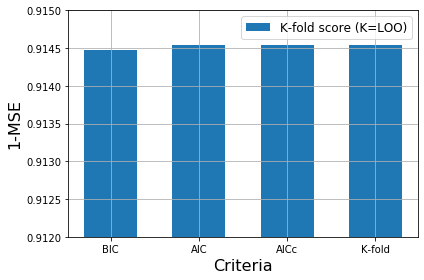

In [74]:
Ylabel = '1-MSE'
Xlabel = 'Criteria'

plotVar1label = 'K-fold score (K={})'.format(K_set)
# plotVar2label = 'K = 5'
# plotVar3label = 'K = 3'

LegendLocation = 'best'
# LegendLocation = 4
Grid = True
LegendSize = 12
FontSize = 16

plt.bar(list_name, list_k, label=plotVar1label, width = 0.6)
plt.legend(loc=LegendLocation, numpoints = 1, fontsize=FontSize, prop={'size':LegendSize})

if response == 'rheomix final deg time min':
    plt.ylim([0.9, 0.93])
elif response == 'rheomix stability time min':
    plt.ylim([0.912, 0.915])
plt.ylabel(Ylabel, fontsize=FontSize)
plt.xlabel(Xlabel, fontsize=FontSize)
# plt.tick_params(axis='x', labelsize=FontSize)
# plt.tick_params(axis='y', labelsize=FontSize)
plt.grid(zorder = 0)
plt.tight_layout()
plt.savefig('Criteria_all_compare_{}.png'.format(response))